In [2]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import xarray as xr
import numpy as np
import pandas as pd
import glob
import calendar
import seaborn as sns
import seaborn_image as isns

In [3]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

In [4]:
import plotly.io as pio
pio.renderers.default='jupyterlab'

In [5]:
plt.style.use('seaborn-pastel')
isns.set_context(mode="notebook", fontfamily="Times")
sns.set_context(font_scale=0.8)

In [6]:
data_baseline = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/mld&sst&swt/SST_2.6/sst_baseline_2.6_cropped.nc')

In [7]:
data_oae = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/mld&sst&swt/SST_2.6/sst_OAE_2.6_cropped.nc')

In [8]:
data_baseline = data_baseline.isel(time=0)
data_oae = data_oae.isel(time=0)

### Map of EU Seasonal Average of sst without OAE

In [9]:
month_length = data_baseline.time_counter.dt.days_in_month 
weights = (month_length.groupby("time_counter.season") / month_length.groupby("time_counter.season").sum())
np.testing.assert_allclose(weights.groupby('time_counter.season').sum().values, np.ones(4))
ds_weighted_baseline = (data_baseline * weights).groupby("time_counter.season").sum(dim="time_counter")

In [10]:
ds_weighted_baseline = ds_weighted_baseline.where(ds_weighted_baseline)

In [11]:
ds_unweighted_baseline = data_baseline.groupby("time_counter.season").mean("time_counter")
ds_diff_baseline = ds_weighted_baseline - ds_unweighted_baseline

In [12]:
baseline_djf = (ds_weighted_baseline.sst.isel(season=0)).to_dataset(name='sst')
baseline_jja = (ds_weighted_baseline.sst.isel(season=1)).to_dataset(name='sst')
baseline_mam = (ds_weighted_baseline.sst.isel(season=2)).to_dataset(name='sst')
baseline_son = (ds_weighted_baseline.sst.isel(season=3)).to_dataset(name='sst')

### Map of EU Seasonal Average of sst with OAE

In [13]:
month_length = data_oae.time_counter.dt.days_in_month 
weights = (month_length.groupby("time_counter.season") / month_length.groupby("time_counter.season").sum())
np.testing.assert_allclose(weights.groupby('time_counter.season').sum().values, np.ones(4))
ds_weighted_oae = (data_oae * weights).groupby("time_counter.season").sum(dim="time_counter")

In [14]:
ds_weighted_oae = ds_weighted_oae.where(ds_weighted_oae)

In [15]:
ds_unweighted_oae = data_oae.groupby("time_counter.season").mean("time_counter")
ds_diff_oae = ds_weighted_oae - ds_unweighted_oae

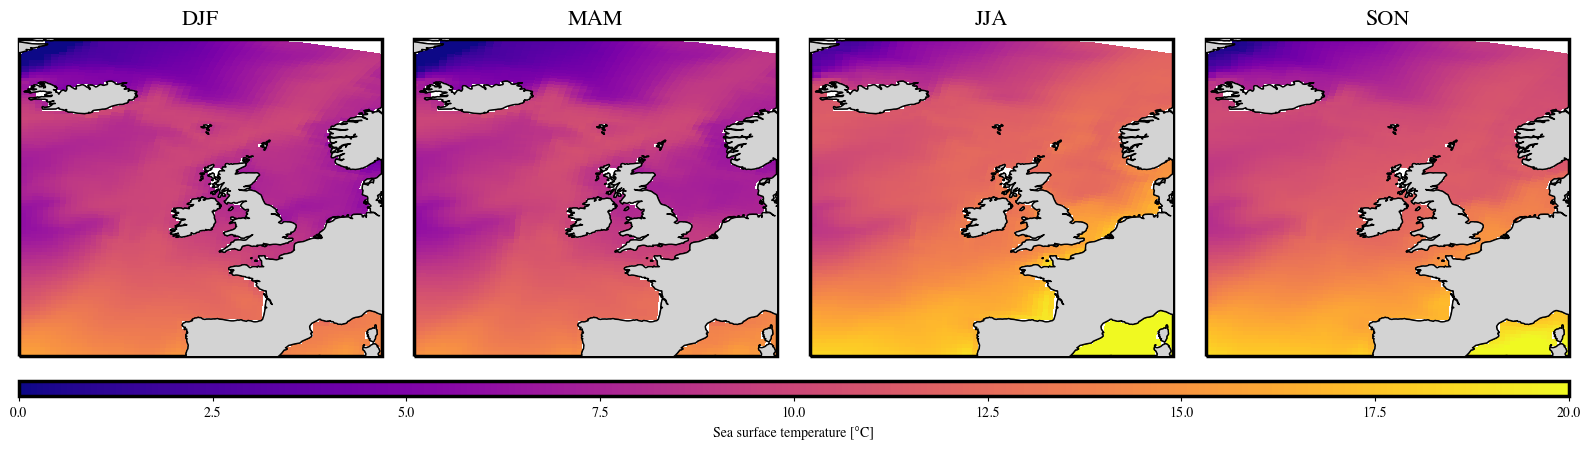

In [16]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20, 8))
plt.subplots_adjust(wspace=0.09, hspace=0.05)

im0 = baseline_djf.sst.plot.pcolormesh(
        ax=ax0, x="nav_lon", y="nav_lat",
        vmin=0,
        vmax=20,
        cmap="plasma",
        add_colorbar=False
    )

im1 = baseline_mam.sst.plot.pcolormesh(
        ax=ax1, x="nav_lon", y="nav_lat",
        vmin=0,
        vmax=20,
        cmap="plasma",
        add_colorbar=False
    )
    
im2 = baseline_jja.sst.plot.pcolormesh(
        ax=ax2, x="nav_lon", y="nav_lat",
        vmin=0,
        vmax=20,
        cmap="plasma",
        add_colorbar=False
    )
    
im3 = baseline_son.sst.plot.pcolormesh( 
        ax=ax3, x="nav_lon", y="nav_lat",
        vmin=0,
        vmax=20,
        cmap="plasma",
        add_colorbar=False
    )

axes = [ax0, ax1, ax2, ax3]

for ax in axes:
    ax.coastlines()
    ax.set_extent([-25, 10, 40, 70])
    ax.add_feature(cfeature.LAND, zorder=100, facecolor='lightgrey', edgecolor='black')

for ax in axes: 
    if ax == ax0:
        ax.set_title("DJF", fontsize=16, y=1.02),
    elif ax == ax1:
        ax.set_title("MAM", fontsize=16, y=1.02),
    elif ax == ax2:
        ax.set_title("JJA", fontsize=16, y=1.02),
    else:
        ax.set_title("SON", fontsize=16, y=1.02)    

font_size = 10
        
cbar = plt.colorbar(im1, ax = axes, aspect =100, pad=0.04, location='bottom')
cbar.set_label('Sea surface temperature [°C]', fontsize=10)
cbar.ax.tick_params(labelsize=font_size)

pass

plt.savefig('/Users/chiaraciscato/Desktop/geomar/geomarcode/SSP1_2.6/sst&mld&swt&wind/figures/sst.png')

In [17]:
hovm_base = data_baseline.where((data_baseline.nav_lat > 53) & (data_baseline.nav_lat < 60) \
            & (data_baseline.nav_lon > 2) & (data_baseline.nav_lon < 3), drop=True)

In [18]:
month_length_base = data_baseline.time_counter.dt.days_in_month
hovm_base_month = ((data_baseline * month_length_base).resample(time_counter='M').sum() / month_length_base.resample(time_counter='M').sum())

In [19]:
hovm_base_month = hovm_base.sst.groupby('time_counter.month').mean(dim=('time_counter', 'x'))

In [20]:
hovm_base_month = hovm_base_month.to_dataset(name='sst')

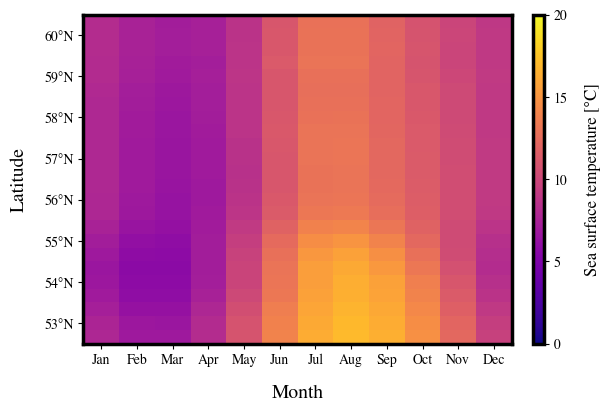

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
im = hovm_base_month.sst.plot.pcolormesh(
        ax=ax,
        vmin=0,
        vmax=20,
        cmap="plasma",
        add_colorbar=False
)

cbar = plt.colorbar(im, ax=ax, aspect = 30, pad=0.05, location='right', ticks=[0, 5, 10, 15, 20])
cbar.set_label('Sea surface temperature [°C]', fontsize=12, labelpad=12)
cbar.ax.set_yticklabels(['0', '5', '10', '15', '20'])

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel('Latitude', fontsize=14, labelpad=12)
ax.set_xlabel('Month', fontsize=14, labelpad=12)

x = list(range(1,13))
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
labels_month = [item.get_text() for item in ax.get_xticklabels()]
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels(month_label, fontsize=10)

y = list(range(1,24))
plt.yticks(np.arange(min(y), max(y)+1, 3))
labels_lat = [item.get_text() for item in ax.get_yticklabels()]
lat_label = ['53°N', '54°N', '55°N', '56°N', '57°N', '58°N', '59°N', '60°N']
ax.set_yticklabels(lat_label, fontsize=10)

for t in cbar.ax.get_yticklabels():
     t.set_fontsize(10)
        
plt.title('')

plt.savefig('/Users/chiaraciscato/Desktop/geomar/geomarcode/SSP1_2.6/sst&mld&swt&wind/figures/sstmap.png')